In [1]:
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, SimpleRNN
from keras.utils import np_utils
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
from IPython.display import clear_output
import mido
import glob, pickle
import sys
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt

Using TensorFlow backend.


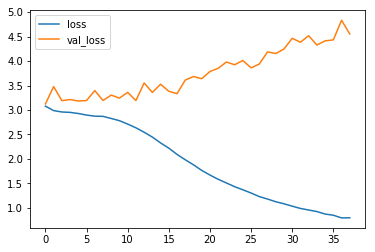

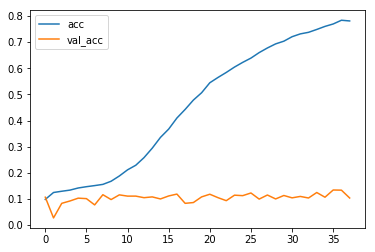

6666/6666 [==============================] - 4s 587us/sample - loss: 0.7973 - acc: 0.7810 - val_loss: 4.5529 - val_acc: 0.1038
Epoch 39/200
3392/6666 [==============>...............] - ETA: 1s - loss: 0.7575 - acc: 0.7948

KeyboardInterrupt: 

In [31]:
def train_network():
    """ Train a Neural Network to generate music """
    with open('data/notes', 'rb') as filepath:
        notes = pickle.load(filepath)
    
    #use only an eighth quarter of our dataset
    # len_notes = len(notes)
    # ab_notes = len_notes // 8
    
    # notes = notes[0:ab_notes]
    
    # get amount of pitch names
    # n_vocab = len(set(np.ndarray.flatten(np.array(notes))))
    unpacked_notes = []
    
    for item in notes:
        unpacked_notes.extend(item)
    
    n_vocab = len(set(unpacked_notes))

    network_input, network_output = prepare_sequences(notes, n_vocab)

    model = create_network(network_input, n_vocab)
    
    np.save("a", network_input)
    np.save("b", network_output)

    return train(model, network_input, network_output)

def prepare_sequences(notes, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 50
    
    unpacked_notes = []
    
    for item in notes:
        unpacked_notes.extend(item)

    # get all pitch names
    pitchnames = sorted(set(item for item in unpacked_notes))

     # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for song in notes:
        for i in range(0, len(song) - sequence_length):
            sequence_in = song[i:i + sequence_length]
            sequence_out = song[i + sequence_length]
            network_input.append([note_to_int[char] for char in sequence_in])
            network_output.append(note_to_int[sequence_out])
    
    assert len(network_input) == len(network_output), len(network_input)

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    # do not reshape coz this is a normal regression
    network_input = np.array(network_input)
    assert network_input.shape == (n_patterns, sequence_length)
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    network_input = network_input / float(n_vocab)

    network_output = np_utils.to_categorical(network_output)

    return (network_input, network_output)

def create_network(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(SimpleRNN(
        256,
        return_sequences=False,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        kernel_regularizer=regularizers.l2(0.01)
    ))
    model.add(Dense(n_vocab))
    model.add(Activation("softmax"))
    model.compile(loss='categorical_crossentropy', optimizer="rmsprop", metrics=['accuracy'])

    return model

def train(model, network_input, network_output):
    """ train the neural network """
    filepath = "checkpoints-RNN-simple/weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
    checkpoint = ModelCheckpoint(
        filepath,
        monitor='loss',
        verbose=0,
        save_best_only=True,
        mode='min'
    )
    
    plot = live_plot()
    
    callbacks_list = [checkpoint, plot]

    history_object = model.fit(network_input, network_output, 
                               epochs=200, batch_size=64,
                               validation_split=0.2,
                               callbacks=callbacks_list)
    return history_object

class live_plot(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.index = 0
        self.epochs = []
        
        self.losses = []
        self.val_losses = []
        
        self.acc = []
        self.val_acc = []
        
        self.figure = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.epochs.append(self.index)
        
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.index += 1
        
        clear_output(wait=True)
        plt.plot(self.epochs, self.losses, label="loss")
        plt.plot(self.epochs, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
        plt.plot(self.epochs, self.acc, label="acc")
        plt.plot(self.epochs, self.val_acc, label="val_acc")
        plt.legend()
        plt.show();

if __name__ == '__main__':
	history_object = train_network()

In [18]:
model = Sequential()
model.add(SimpleRNN(
        256,
        dropout=0.1,
        input_shape=(500, 1)
    ))
model.add(Dense(10))
model.add(Activation("softmax"))
model.compile(loss='categorical_crossentropy', optimizer="rmsprop", metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_9 (SimpleRNN)     (None, 256)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 68,618
Trainable params: 68,618
Non-trainable params: 0
_________________________________________________________________


In [24]:
with open('data/notes', 'rb') as filepath:
        notes = pickle.load(filepath)

In [26]:
len(notes)

402